# Library

In [1]:
%matplotlib inline
import datetime
import time
timeformat = "%Y-%m-%d %H:%M:%S"

from sklearn import neural_network
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams['figure.figsize'] = [16.0, 8.0]
colors = {'MLP':'C3', 'RT':'C2', 'LR':'C1', 'Real':'C0'}

# Global

In [2]:
predict = dict()

# Function

# Data preprocess

In [3]:
pm25 = pd.read_csv("../data/Erlin.csv", parse_dates=True)[['PM2.5']]
pm25.columns = ["PM25"]

In [4]:
#meteorology = pd.read_csv("../data/Erlin.csv", parse_dates=True)
#meteorology = pd.read_csv("../data/Erlin_minmax.csv", parse_dates=True)
meteorology = pd.read_csv("../data/Erlin_zscore.csv", parse_dates=True)
#meteorology = pd.read_csv("../data/Erlin_normalization.csv", parse_dates=True)
meteorology = meteorology[['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED']]

## to forecast PM2.5(t), we use RAINFALL(t-1) instead of RAINFALL(t)
## cause we could not know RAINFALL(t) from weather forecast
meteorology.RAINFALL = meteorology.RAINFALL.shift()

In [5]:
date_feature = pd.read_csv("../data/date_feature.csv", parse_dates=True)

In [6]:
time_series = pd.read_csv("../data/pm2.5_timeseries.csv", parse_dates=True)
time_series = time_series[[column for column in time_series.columns if column not in ['datetime']]]
time_lags = ['t-'+str(x+1) for x in range(12)]
time_series = time_series[time_lags]

In [7]:
data = pd.concat([pm25, meteorology, time_series, date_feature], axis=1)

In [8]:
target = "PM25"
exclude = ['datetime', target]
features = [f for f in data.columns if f not in exclude]
week = ['weekday_'+str(x+1) for x in range(7)]
season = ['season_'+str(x+1) for x in range(4)]
hour = ['hour_'+str(x) for x in range(24)]
meteor = ['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED']
#features = [f for f in features if f not in week and f not in season and f not in hour]
print features

['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'season_1', 'season_2', 'season_3', 'season_4']


In [9]:
forecast_hour = 12
data.PM25 = data.PM25.shift(1-forecast_hour)

# Data

In [10]:
DateStart = '2016-06-01 00:00:00'
DateEnd = '2016-12-31 00:00:00'

start = data[data.datetime.values == DateStart].index[0]
end = data[data.datetime.values == DateEnd].index[0]

#train = pd.concat([data[:start], data[end:]], axis=0).dropna()
train = data[:start].dropna()
test = data[start:end].dropna()

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Regression Tree

In [11]:
'''
start_time = time.time()

RT = AdaBoostRegressor(DecisionTreeRegressor())
RT.fit(X_train, y_train)
zipped = sorted(zip(features, RT.feature_importances_), key = lambda imp: imp[1])
print 'Feature : Importances'
for f, imp in zipped:
    print f, ':', imp

predict["RT"] = RT.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'
'''

'\nstart_time = time.time()\n\nRT = AdaBoostRegressor(DecisionTreeRegressor())\nRT.fit(X_train, y_train)\nzipped = sorted(zip(features, RT.feature_importances_), key = lambda imp: imp[1])\nprint \'Feature : Importances\'\nfor f, imp in zipped:\n    print f, \':\', imp\n\npredict["RT"] = RT.predict(X_test)\n\nend_time = time.time()\nprint "Time consume: ", end_time - start_time, \' s.\'\n'

# Linear Regression

In [12]:
start_time = time.time()

LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)
zipped = sorted(zip(features, LR.coef_), key = lambda coef: coef[1])
print 'Feature : Coefficients'
for f, coef in zipped:
    print f, ':', coef

predict["LR"] = LR.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Feature : Coefficients
WIND_SPEED : -3.7841841719
AMB_TEMP : -3.46364902037
hour_18 : -3.30565628056
hour_19 : -3.19247677469
RH : -2.91256887396
hour_17 : -2.45889494854
season_2 : -1.97329012738
hour_20 : -1.7478604915
hour_16 : -1.48079607282
weekday_2 : -1.11716583229
weekday_7 : -0.722976737118
hour_15 : -0.557343201607
hour_10 : -0.526077852633
season_4 : -0.497353850125
hour_11 : -0.435729225304
hour_12 : -0.300745126954
hour_14 : -0.242179321347
hour_13 : -0.184627815549
weekday_4 : -0.170513945675
RAINFALL : -0.142747043927
t-2 : -0.114090089665
t-5 : -0.0641759953729
t-8 : -0.0458284774669
t-3 : -0.0385969935431
t-11 : -0.0235730278686
t-6 : 0.00266338255651
t-10 : 0.0329390834262
t-9 : 0.0440731135778
t-7 : 0.0858898182108
hour_4 : 0.108843556273
t-12 : 0.125298831605
t-4 : 0.167373398651
hour_9 : 0.173636572277
weekday_3 : 0.327959926351
weekday_5 : 0.359424420967
t-1 : 0.361928316931
hour_5 : 0.408849323058
hour_3 : 0.413357416955
hour_21 : 0.46751198939
season_1 : 0.56490

In [13]:
test[-1:]

,PM25,AMB_TEMP,RAINFALL,RH,WIND_SPEED,t-1,t-2,t-3,t-4,t-5,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,season_1,season_2,season_3,season_4
87647,10.0,-1.052484,-0.109118,0.429106,-0.685391,16.0,21.0,24.0,20.0,22.0,...,0,0,0,1,0,0,0,0,0,1


In [14]:
LR.predict(X_test[-1:])

array([ 32.02493668])

# MLP Regression

In [15]:
start_time = time.time()

MLP = neural_network.MLPRegressor(activation='relu')
MLP.fit(X_train, y_train)
print 'Model: \n', MLP

predict["MLP"] = MLP.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

Model: 
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Time consume:  26.3612139225  s.


# Measure

In [16]:
rmse = dict()
rmse['model'], rmse['value'] = [], []
for key, value in predict.iteritems():
    rmse['model'].append(key)
    rmse['value'].append(sqrt(mean_squared_error(value, y_test)))

print rmse

{'model': ['MLP', 'LR'], 'value': [14.085852904143023, 14.68162281374]}


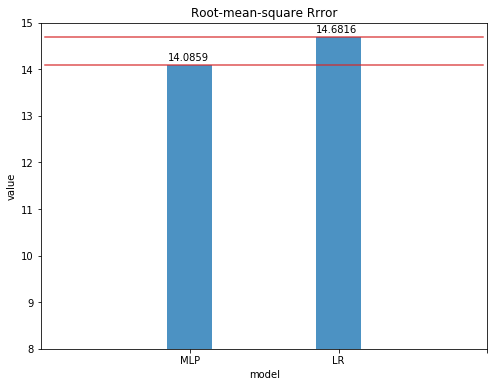

In [17]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.bar(range(len(rmse['model'])), rmse['value'], width=0.3, color='C0', alpha=0.8)
for x in range(len(rmse['value'])):
    plt.axhline(y=rmse['value'][x], color='C3', xmin=0.01, xmax=0.99, alpha=0.8)
    plt.text(x - 0.15 , rmse['value'][x] + 0.1, str(round(rmse['value'][x], 4)), color='k')
plt.xticks(range(3), rmse['model'])
plt.title('Root-mean-square Rrror')
plt.xlabel('model')
plt.ylabel('value')
plt.ylim([8,15])
plt.xlim([-1,2])
fig = plt.gcf()
plt.show()

# Plot

In [18]:
plt.rcParams['figure.figsize'] = [16.0, 6.0]

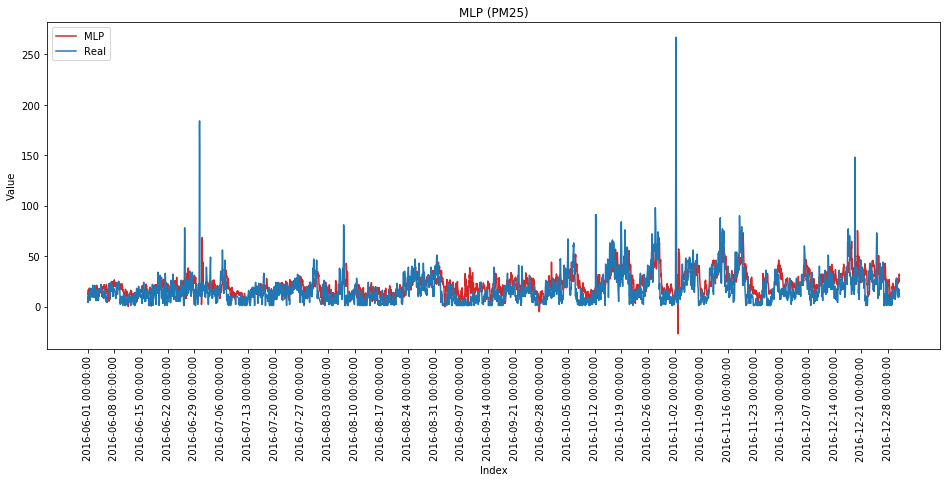

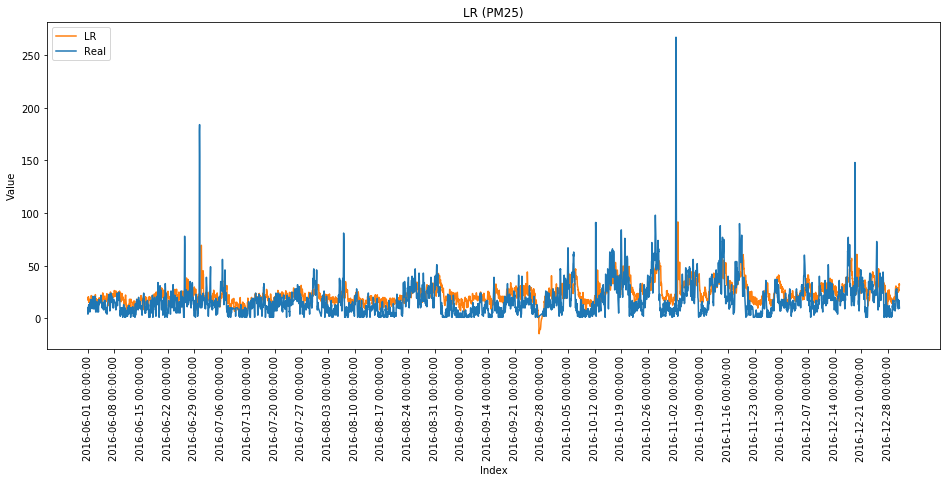

In [19]:
for key, value in predict.iteritems():
    plt.title(key + ' (' + target + ')')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.plot(value, colors[key], label = key)
    plt.plot(y_test.tolist(), colors['Real'], label = 'Real')
    plt.xticks(range(0,len(predict[key]),24*7), test.datetime.tolist()[::24*7])
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    plt.savefig('../output/' + key + '_rmse.png')
    plt.show()

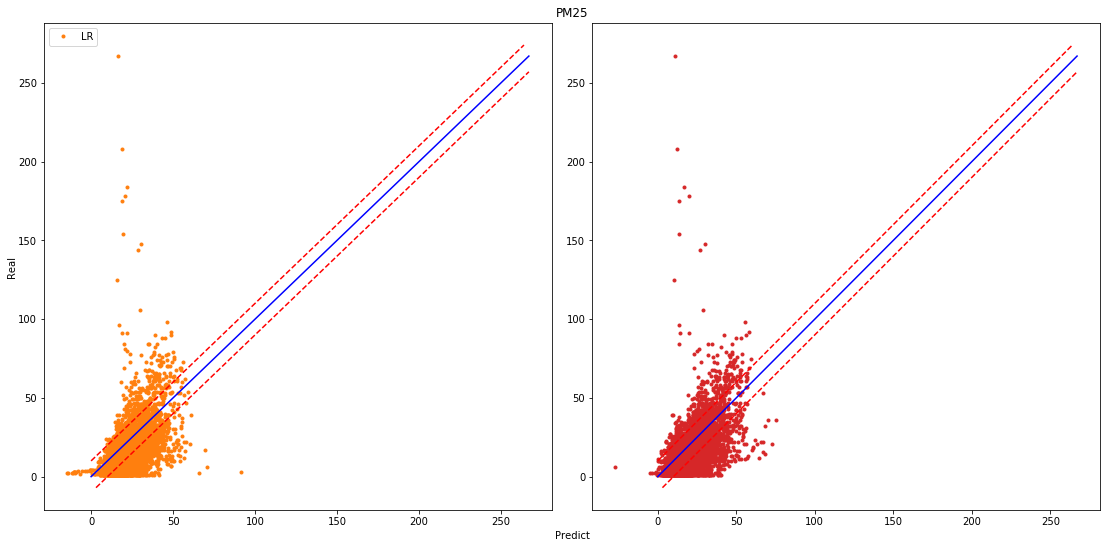

In [20]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.title.set_text(target)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Predict')
ax.set_ylabel('Real')

subplot = {'LR':121, 'MLP':122}
for key, value in predict.iteritems():
    sub_ax = fig.add_subplot(subplot[key])
    sub_ax.plot(value, y_test.tolist(), colors[key] + '.', label=key)
    
    a, b = 0, max(max(y_test.tolist()), 24)
    mrange = 10 
    sub_ax.plot([a, b], [a, b], 'b-')
    sub_ax.plot([a, b - 3], [a+mrange, b+mrange -3], 'r--')
    sub_ax.plot([a + 3, b], [a-mrange + 3, b-mrange], 'r--')
    
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
proportion = dict()
real = y_test.tolist()
threshold = [5, 10]
print "Threshold : ", threshold
for key, value in predict.iteritems():
    proportion[key] = list()
    zipped = zip(real, value)
    for t in threshold:
        count = 0
        for r, v in zipped:
            if abs(r - v) < t:
                count = count+1
        proportion[key].append(100.0 * count / len(real))
    print key, ":", proportion[key]


Threshold :  [5, 10]
MLP : [34.19405320813772, 62.20657276995305]
LR : [27.60172143974961, 54.51877934272301]


In [22]:
#impos = zip(features, RT.feature_importances_)
coefs = zip(features, LR.coef_)

In [23]:
'''plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.bar(range(len(impos)), [v for f, v in impos])
for x in range(len(impos)):
    v = impos[x][1]
    if v > 0.01:
        plt.text(x - 0.25 , v + 0.03 , str(round(v, 2)), color='k', rotation=90)
plt.xticks(range(len(impos)), [f for f, v in impos])
plt.xticks(rotation=90)
plt.savefig('../output/importances.png')
plt.show()'''

"plt.rcParams['figure.figsize'] = [16.0, 8.0]\nplt.bar(range(len(impos)), [v for f, v in impos])\nfor x in range(len(impos)):\n    v = impos[x][1]\n    if v > 0.01:\n        plt.text(x - 0.25 , v + 0.03 , str(round(v, 2)), color='k', rotation=90)\nplt.xticks(range(len(impos)), [f for f, v in impos])\nplt.xticks(rotation=90)\nplt.savefig('../output/importances.png')\nplt.show()"

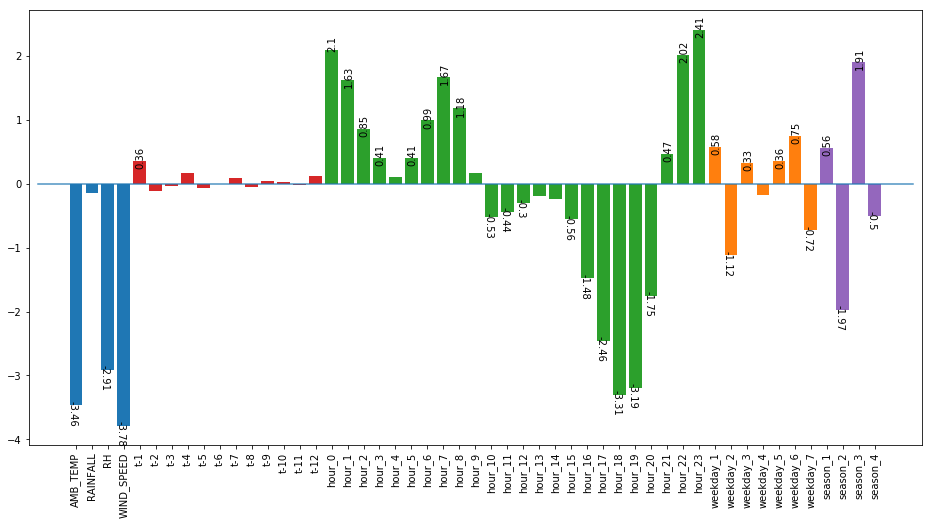

In [24]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
color = {'t':'C3', 'h':'C2', 'w':'C1', 's':'C4'}
for x in range(len(coefs)):
    plt.bar(x, coefs[x][1], color = color[coefs[x][0][0]] if coefs[x][0][0] in color.keys() else 'C0')
for x in range(len(coefs)):
    v = coefs[x][1]
    if v > 0.3:
        plt.text(x - 0.25 , v + 0.1 , str(round(v, 2)), color='k', rotation=90)
    elif  v < -0.3:
        plt.text(x - 0.5 , v - 0.05 , str(round(v, 2)), color='k', rotation=-90)
plt.xticks(range(len(coefs)), [f for f, v in coefs])
plt.xticks(rotation=90)
plt.axhline(color='C0', xmin=0.01, xmax=0.99, alpha=0.8)
plt.savefig('../output/coefficients.png')
plt.show()

In [25]:
#df_impos = pd.DataFrame(dict(impos), index=range(1))
df_coefs = pd.DataFrame(dict(coefs), index=range(1))

In [26]:
#df_impos.to_csv('../output/RT_importances.csv', index=False)
df_coefs.to_csv('../output/LR_coefficients.csv', index=False)